In [ ]:
!unzip /content/drive/MyDrive/parking_detection/IllegalparkingoncityRoad.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/images/frame_0612_jpg.rf.c9ca68205e8595703ae5574d4493791f.jpg  
 extracting: train/images/frame_0612_jpg.rf.e7cf9faa153f301b772724d067742bbc.jpg  
 extracting: train/images/frame_0612_jpg.rf.f00ba43d3910d0ebd8a13db1bd0dab67.jpg  
 extracting: train/images/frame_0612_jpg.rf.f15239a8ab34b928c91dbe602893fc01.jpg  
 extracting: train/images/frame_0624_jpg.rf.0b6d5bc1afe75d72c90688d9e525152d.jpg  
 extracting: train/images/frame_0624_jpg.rf.0d2485fde49331de6a6759c04d75108b.jpg  
 extracting: train/images/frame_0624_jpg.rf.284f42a12296ddbf1bd72978e35615fc.jpg  
 extracting: train/images/frame_0624_jpg.rf.353e3ddfaacbf9ff24f7d9aac5c04af4.jpg  
 extracting: train/images/frame_0624_jpg.rf.633198d901e6f236d06fc5c38a197b8a.jpg  
 extracting: train/images/frame_0624_jpg.rf.67924bf4196eddb49d3ef16181a286de.jpg  
 extracting: train/images/frame_0624_jpg.rf.6850b8404c560459bc02893422a6dd34.jpg  
 extracting: train/images/frame_0624

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install ultralytics
!pip install -U ipywidgets
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.7/871.7 kB 50.0 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
from PIL import Image
import torch
from torch import nn
import random

In [ ]:
import os
train_img_dir = '/content/train/images'
train_images = os.listdir(train_img_dir)

val_img_dir = '/content/valid/images'
val_images = os.listdir(val_img_dir)

train_labels_dir = '/content/train/labels'
val_labels_dir = '/content/valid/labels'


In [ ]:
import yaml
dataset_config = {
    'train': '../train/images',
    'val': '../valid/images',
    'test': '../test/images',
    'nc': 2,
    'names': ['Illegal', 'Legal'],

}

labels_list = dataset_config['names']

print("labels list:")
print(labels_list)


labels list:
['Illegal', 'Legal']


In [ ]:
label_list= ['Illegal', 'Legal']

In [ ]:
def label_name(label_class):
    if 0 <= label_class < len(label_list):
        return label_list[label_class]
    else:
        return "none"

def load_labels(images, labels_dir):
    labels = []
    for img in images:
        label_path = os.path.join(labels_dir, img.replace('.jpg', '.txt'))
        try:
            with open(label_path, "r") as file:
                text = file.read().strip()
            if len(text) < 1:
                labels.append('None')
            else:
                labels.append(int(text.split()[0]))
        except FileNotFoundError:
            labels.append('None')
    return labels

train_labels = load_labels(train_images, train_labels_dir)
val_labels = load_labels(val_images, val_labels_dir)

def convert_labels(labels):
    return [int(label) if label != 'None' else -1 for label in labels]

train_labels = convert_labels(train_labels)
val_labels = convert_labels(val_labels)

In [ ]:
df_train = pd.DataFrame({
    'image_path': train_images,
    'label_class': train_labels
})
df_train['label_name'] = df_train['label_class'].apply(label_name)

df_val = pd.DataFrame({
    'image_path': val_images,
    'label_class': val_labels
})
df_val['label_name'] = df_val['label_class'].apply(label_name)


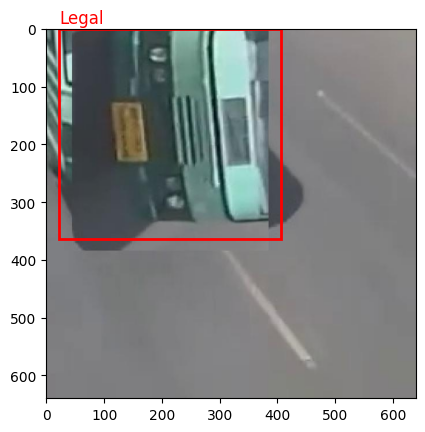

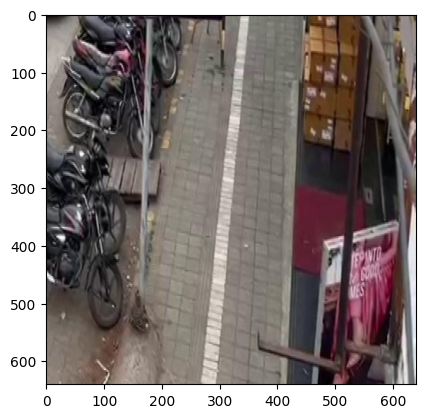

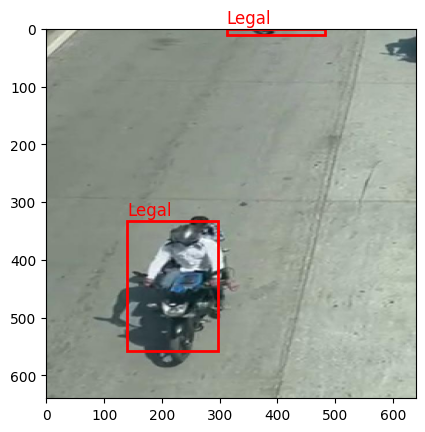

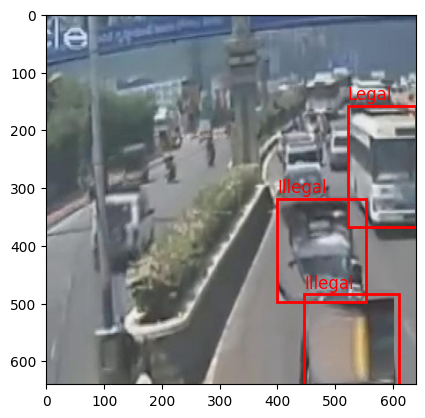

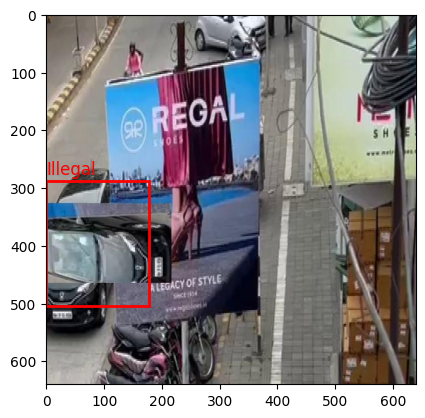

In [ ]:
import matplotlib.patches as patches

def plot_bounding_box(image_path, labels_dir):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_path = os.path.join(labels_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    try:
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.split())
                x_center, y_center, width, height = x_center * img.shape[1], y_center * img.shape[0], width * img.shape[1], height * img.shape[0]
                rect = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                plt.text(x_center - width / 2, y_center - height / 2 - 10, label_name(int(class_id)), color='r', fontsize=12)
    except FileNotFoundError:
        print(f"Label file not found for {image_path}")
    plt.show()


for img_path in df_train['image_path'].sample(5).values:
    plot_bounding_box(os.path.join(train_img_dir, img_path), train_labels_dir)

In [ ]:
import pandas as pd
import plotly.express as px

# Define the label_name function to map numeric classes to descriptive names
def label_name(label_class):
    if label_class == 1:
        return 'Legal'
    elif label_class == 0:
        return 'Illegal'
    else:
        return 'None'

df_train = pd.DataFrame({'label_class': [0, 1, 1, -1]})
df_val = pd.DataFrame({'label_class': [0, 1, -1, 0]})


# Convert 'label_class' to numeric, handling errors by coercing to NaN
df_train['label_class'] = pd.to_numeric(df_train['label_class'], errors='coerce')
df_val['label_class'] = pd.to_numeric(df_val['label_class'], errors='coerce')

# Convert 'label_class' to integers, filling NaN with -1
df_train['label_class'] = df_train['label_class'].fillna(-1).astype(int)
df_val['label_class'] = df_val['label_class'].fillna(-1).astype(int)

# Apply the label_name function to get descriptive names
df_train['label_name'] = df_train['label_class'].apply(label_name)
df_val['label_name'] = df_val['label_class'].apply(label_name)

# Plot histogram for training data
fig_train = px.histogram(df_train.sort_values(by='label_name'), x="label_name", color="label_name", color_discrete_sequence=px.colors.sequential.thermal)
fig_train.update_layout(title='Training Dataset Distribution of Labels', xaxis_title='Classes', yaxis_title="Count")
fig_train.show()

# Plot histogram for validation data
fig_val = px.histogram(df_val.sort_values(by='label_name'), x="label_name", color="label_name", color_discrete_sequence=px.colors.sequential.thermal)
fig_val.update_layout(title='Validation Dataset Distribution of Labels', xaxis_title='Classes', yaxis_title="Count")
fig_val.show()

In [ ]:
import os
import pandas as pd
import plotly.express as px

# Define the label_name function to map numeric classes to descriptive names
def label_name(label_class):
    if label_class == 1:
        return 'Legal'
    elif label_class == 0:
        return 'Illegal'
    else:
        return 'None'

# Function to load YOLO annotation files and extract class labels
def load_yolo_annotations(annotation_dir):
    labels = []
    for file_name in os.listdir(annotation_dir):
        if file_name.endswith('.txt'):
            with open(os.path.join(annotation_dir, file_name), 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    labels.append(class_id)
    return labels

# Load the training and validation labels from the annotation files
train_annotation_dir = '/content/train/labels'
val_annotation_dir = '/content/valid/labels'

# Ensure that annotation directories exist
assert os.path.exists(train_annotation_dir), f"Training annotation directory does not exist: {train_annotation_dir}"
assert os.path.exists(val_annotation_dir), f"Validation annotation directory does not exist: {val_annotation_dir}"

# Load annotations
train_labels = load_yolo_annotations(train_annotation_dir)
val_labels = load_yolo_annotations(val_annotation_dir)

# Debugging: Print out the number of labels loaded for training and validation sets
print(f"Number of training labels loaded: {len(train_labels)}")
print(f"Number of validation labels loaded: {len(val_labels)}")

# Create DataFrames
df_train = pd.DataFrame({'label_class': train_labels})
df_val = pd.DataFrame({'label_class': val_labels})

# Convert 'label_class' to integers
df_train['label_class'] = df_train['label_class'].astype(int)
df_val['label_class'] = df_val['label_class'].astype(int)

# Apply the label_name function to get descriptive names
df_train['label_name'] = df_train['label_class'].apply(label_name)
df_val['label_name'] = df_val['label_class'].apply(label_name)

# Plot histogram for training data
fig_train = px.histogram(df_train.sort_values(by='label_name'), x="label_name", color="label_name", color_discrete_sequence=px.colors.sequential.thermal)
fig_train.update_layout(title='Training Dataset Distribution of Labels', xaxis_title='Classes', yaxis_title="Count", width=500, height=450)
fig_train.show()

# Plot histogram for validation data
fig_val = px.histogram(df_val.sort_values(by='label_name'), x="label_name", color="label_name", color_discrete_sequence=px.colors.sequential.thermal)
fig_val.update_layout(title='Validation Dataset Distribution of Labels', xaxis_title='Classes', yaxis_title="Count", width=500, height=450)
fig_val.show()


Number of training labels loaded: 4809
Number of validation labels loaded: 317


In [ ]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def _init_(self, kernel_size=7):
        super(SpatialAttention, self)._init_()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class YOLOv9WithAttention(nn.Module):
    def __init__(self, yolo_model):
        super(YOLOv9WithAttention, self).__init__()
        self.backbone = yolo_model.model.model[0]
        self.neck = yolo_model.model.model[1]
        self.head = yolo_model.model.model[2]
        self.spatial_attention = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.backbone(x)
        x = self.spatial_attention(x) * x
        x = self.neck(x)
        x = self.head(x)
        return x

# Load the pre-trained YOLOv9 model
yolo_model = YOLO("yolov9c.pt")

# Integrate the spatial attention module
model_with_attention = YOLOv9WithAttention(yolo_model)
import torch
import torch.nn as nn
from ultralytics import YOLO

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class YOLOv9WithAttention(nn.Module):
    def __init__(self, yolo_model):
        super(YOLOv9WithAttention, self).__init__()
        self.backbone = yolo_model.model.model[0]
        self.neck = yolo_model.model.model[1]
        self.head = yolo_model.model.model[2]
        self.spatial_attention = SpatialAttention(kernel_size=7)

    def forward(self, x):
        x = self.backbone(x)
        x = self.spatial_attention(x) * x
        x = self.neck(x)
        x = self.head(x)
        return x

# Load the pre-trained YOLOv9 model
yolo_model = YOLO("yolov9c.pt")

# Integrate the spatial attention module
model_with_attention = YOLOv9WithAttention(yolo_model)


100%|██████████| 49.4M/49.4M [00:00<00:00, 235MB/s]


In [ ]:
# api key 9b4e6d2906714734aabb571ac370a76d66c97405

In [ ]:
model = YOLO("yolov9c.pt")

model.train(data="/content/data.yaml", epochs=50, imgsz=640, lr0=0.0001, dropout=0.15)


Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.15, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 106MB/s]
Exception ignored in: <function _xla_gc_callback at 0x789d4786a440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 318MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 3268 images, 835 backgrounds, 0 corrupt: 100%|██████████| 3268/3268 [00:01<00:00, 2364.35it/s]


train: New cache created: /content/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 87, len(boxes) = 4809. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

val: Scanning /content/valid/labels... 224 images, 65 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 1673.77it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.3G      1.829      2.514      1.946         14        640: 100%|██████████| 205/205 [02:55<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        224        317      0.169      0.216      0.132     0.0438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.1G      2.004      2.593      2.127          6        640: 100%|██████████| 205/205 [02:51<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]

                   all        224        317      0.145      0.127     0.0779     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.1G      1.978      2.515      2.113          8        640: 100%|██████████| 205/205 [02:50<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        224        317      0.196       0.27      0.157     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50        11G      1.902      2.382      2.055          2        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.265      0.216      0.139       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.1G      1.839      2.264      2.006          2        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        224        317      0.416      0.292      0.265      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.1G      1.745      2.097      1.923         20        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        224        317      0.415      0.364       0.35      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.1G       1.71      2.046      1.898          7        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        224        317       0.37       0.32       0.29      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50        11G       1.62      1.904      1.808          8        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        224        317      0.464      0.503       0.43      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.1G      1.614        1.9      1.811          4        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.488      0.467      0.454       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.1G       1.58      1.816      1.784         16        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        224        317      0.586      0.388      0.427      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.1G      1.525      1.737      1.731         10        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        224        317      0.525      0.457      0.434      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        11G      1.497      1.697      1.708          7        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        224        317      0.454      0.404      0.363      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.1G      1.484      1.672      1.701         10        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        224        317      0.516      0.525      0.489      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.1G      1.457      1.628       1.68          5        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        224        317      0.444      0.536      0.453      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.1G      1.446      1.623      1.682         11        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.536      0.514      0.486      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        11G      1.412      1.553      1.646         11        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

                   all        224        317      0.521      0.547      0.532      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.1G      1.383      1.526      1.611         14        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        224        317      0.557      0.463      0.489      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.1G      1.357      1.482      1.591          7        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        224        317      0.525       0.48      0.489      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.1G      1.338      1.453      1.586         12        640: 100%|██████████| 205/205 [02:48<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        224        317      0.613      0.547      0.536      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        11G      1.311       1.41       1.56          4        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        224        317      0.564      0.512      0.495      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.1G      1.304      1.405      1.561         11        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        224        317      0.549      0.564       0.52      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.1G      1.316      1.402      1.565          9        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]

                   all        224        317      0.582      0.541      0.539      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.1G      1.279      1.366      1.536         13        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.559      0.523      0.536      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        11G      1.264      1.321      1.517          8        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        224        317      0.627      0.559      0.574       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.1G      1.246       1.32      1.511          3        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.513      0.619      0.551      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.1G      1.212      1.276        1.5         10        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        224        317      0.637      0.569      0.579      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.1G      1.176       1.23      1.467          2        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        224        317      0.626      0.552      0.567      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50        11G      1.204       1.25      1.494          6        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        224        317      0.638      0.561      0.587      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.2G      1.179      1.207      1.459          7        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        224        317      0.613      0.591      0.577      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.1G       1.15      1.169      1.448         17        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        224        317      0.627       0.57      0.582       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.1G      1.147      1.191      1.449          6        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.576      0.643      0.598       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50        11G      1.114      1.149      1.422          8        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.633      0.615      0.595      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.1G      1.128      1.153       1.44          7        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        224        317      0.685      0.517      0.564      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.1G      1.095      1.104      1.403          7        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.527      0.575      0.561      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.1G        1.1      1.112       1.41         10        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        224        317      0.652      0.586      0.594      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50        11G      1.075      1.085      1.385         11        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        224        317      0.642       0.59      0.583        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.1G      1.066      1.078      1.384         13        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        224        317      0.608      0.621      0.596      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.1G      1.041      1.051      1.367         10        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        224        317      0.628       0.61      0.614      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.1G      1.023      1.041      1.366          3        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        224        317      0.642        0.6      0.601      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.1G      1.026      1.022       1.36          5        640: 100%|██████████| 205/205 [02:48<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317      0.593      0.577      0.577      0.301


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.1G      1.043     0.9179      1.445          6        640: 100%|██████████| 205/205 [02:51<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        224        317      0.662      0.584       0.63      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.1G      1.015     0.8718      1.418          5        640: 100%|██████████| 205/205 [02:48<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        224        317      0.604      0.639      0.618      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.1G      1.005     0.8655      1.418          5        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        224        317      0.603      0.608      0.615      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50        11G     0.9778     0.8449      1.416          3        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

                   all        224        317      0.581      0.662       0.61      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.1G     0.9711     0.8201      1.395          3        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        224        317       0.62       0.62      0.611      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.1G     0.9425     0.7997       1.37          4        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        224        317      0.651      0.595       0.61      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.1G     0.9378     0.7819      1.382          2        640: 100%|██████████| 205/205 [02:48<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        224        317      0.635      0.583      0.605      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        11G     0.9142     0.7722      1.342          6        640: 100%|██████████| 205/205 [02:48<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        224        317       0.63       0.63      0.624      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.1G     0.9047     0.7533      1.349          8        640: 100%|██████████| 205/205 [02:49<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        224        317      0.595      0.667      0.619       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.1G     0.8838     0.7465      1.317          5        640: 100%|██████████| 205/205 [02:48<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        224        317      0.644      0.612      0.617      0.319



50 epochs completed in 2.463 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 51.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,790 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


                   all        224        317      0.629      0.628      0.624      0.325
               Illegal        102        147       0.79      0.796       0.84      0.485
                 Legal         85        170      0.468       0.46      0.408      0.165
Speed: 0.3ms preprocess, 17.0ms inference, 0.1ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789c083ab8b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
metrics = model.val(data='/content/data.yaml')



Ultralytics YOLOv8.2.87 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25,320,790 parameters, 0 gradients, 102.3 GFLOPs


val: Scanning /content/valid/labels.cache... 224 images, 65 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


                   all        224        317      0.635      0.624      0.622      0.323
               Illegal        102        147       0.79      0.789      0.838      0.483
                 Legal         85        170       0.48      0.459      0.405      0.163
Speed: 0.6ms preprocess, 34.3ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/train22


In [ ]:
from ultralytics import YOLO

# Path to data.yaml
#data_yaml_path = '/content/data.yaml'

# Load the model with the trained weights - Assuming 'best.pt' is in the directory
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # Path to your trained weights file

# Test the model on the test dataset
results = model.predict(data='/content/data.yaml')

# Print the results
print(results)

WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 640x480 (no detections), 48.6ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 384x640 (no detections), 55.3ms
Speed: 2.8ms preprocess, 52.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Illegal', 1: 'Legal'}
obb: None
orig_img: array([[[119, 146, 172],
        [121, 148, 174],
        [122, 152, 177],
        ...,
        [161, 171, 188],
        [160, 170, 187],
        [160, 170, 187]],

       [[120, 147, 173],
        [122, 149, 175],
        [123, 153, 178],
        ...,
        [161, 171, 188],
        [160, 170, 187],
        [160, 170, 187]],

       [[123, 150, 176],
        [124, 151, 177],
  

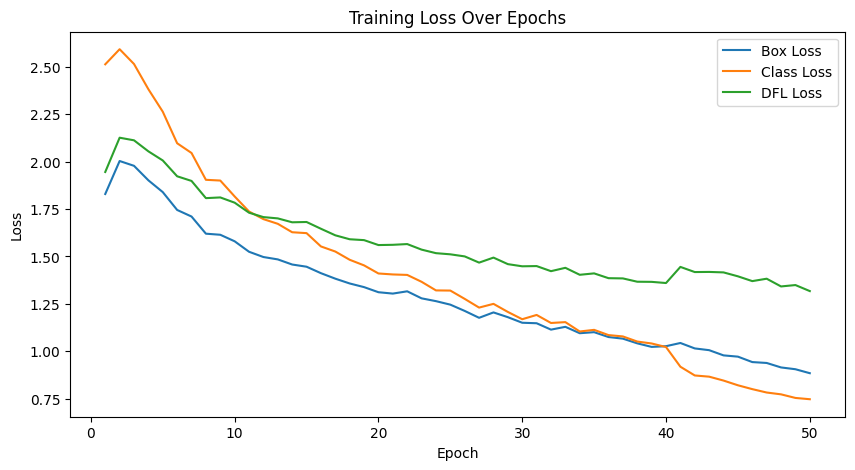

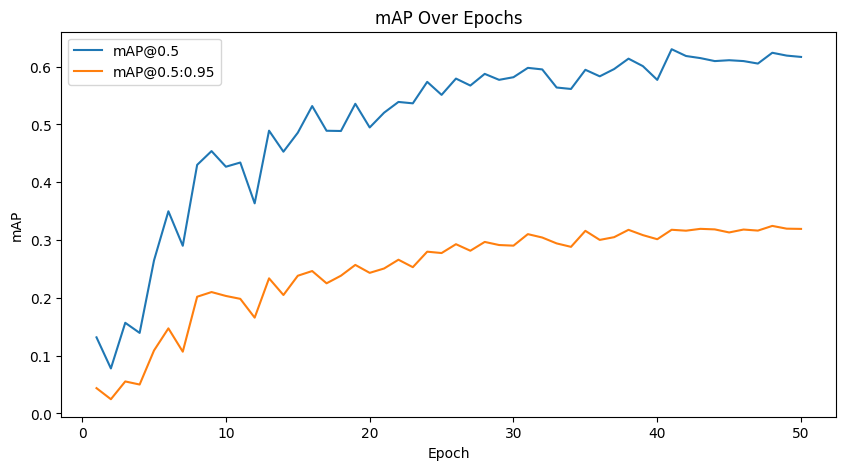

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Path to the results file
results_file = '/content/runs/detect/train2/results.csv'

# Load the results
data = pd.read_csv(results_file)

# Column names based on your data
epochs_col = '                  epoch'
box_loss_col = '         train/box_loss'
cls_loss_col = '         train/cls_loss'
dfl_loss_col = '         train/dfl_loss'
mAP50_col = '       metrics/mAP50(B)'
mAP50_95_col = '    metrics/mAP50-95(B)'

# Extract the data for plotting
epochs = data[epochs_col]
box_loss = data[box_loss_col]
cls_loss = data[cls_loss_col]
dfl_loss = data[dfl_loss_col]
mAP50 = data[mAP50_col]
mAP50_95 = data[mAP50_95_col]

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, box_loss, label="Box Loss")
plt.plot(epochs, cls_loss, label="Class Loss")
plt.plot(epochs, dfl_loss, label="DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# Plot mAP over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP50, label="mAP@0.5")
plt.plot(epochs, mAP50_95, label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("mAP Over Epochs")
plt.legend()
plt.show()


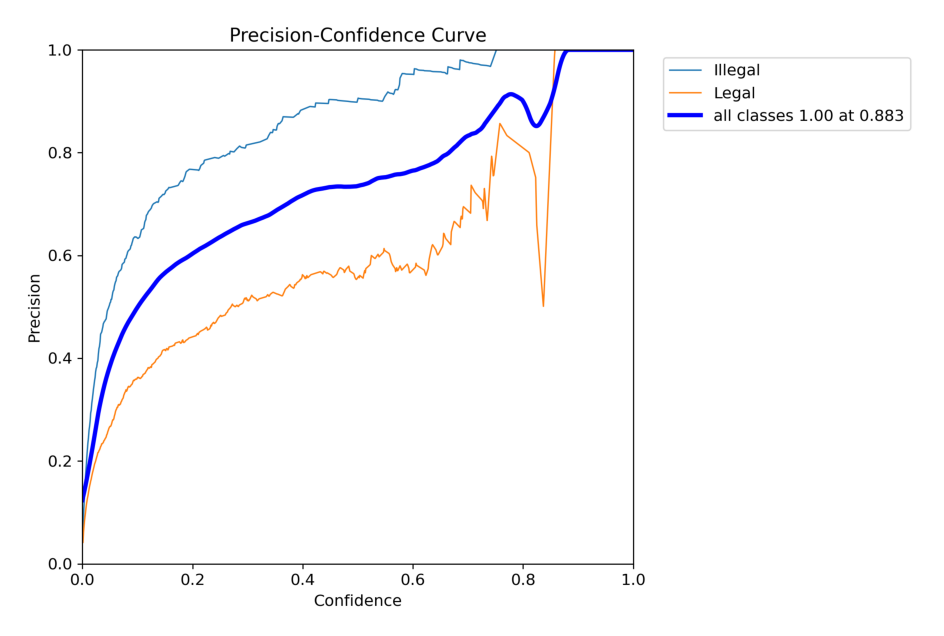

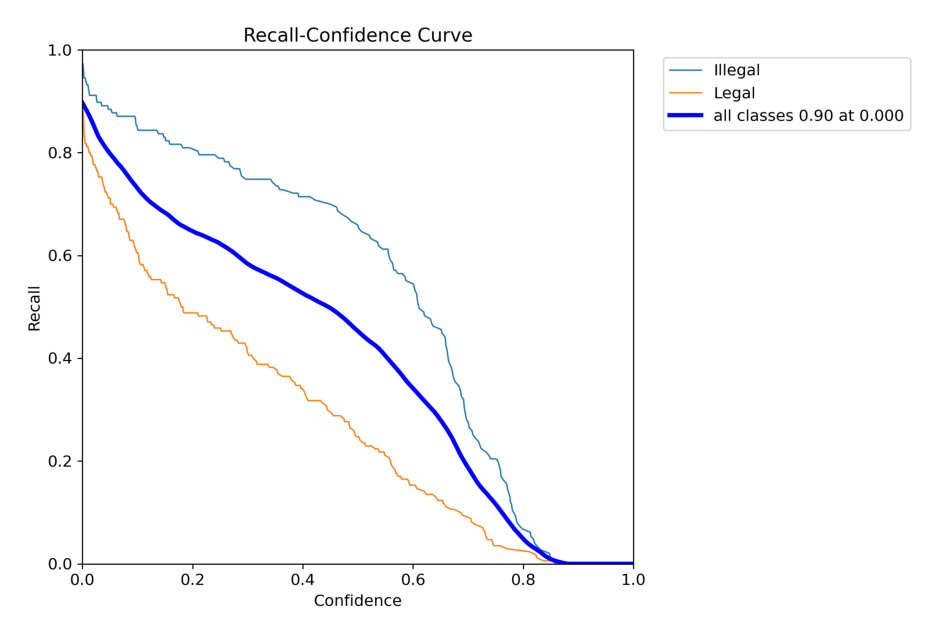

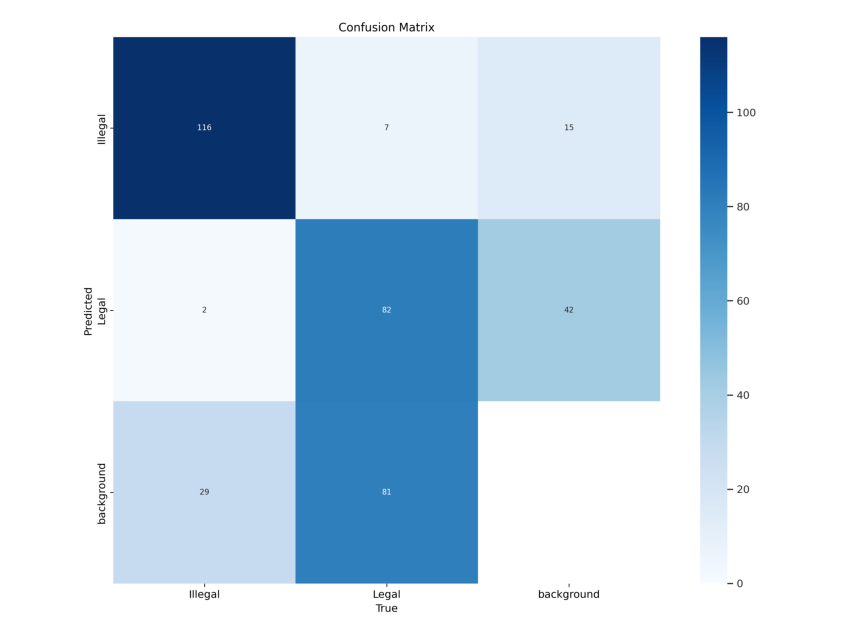

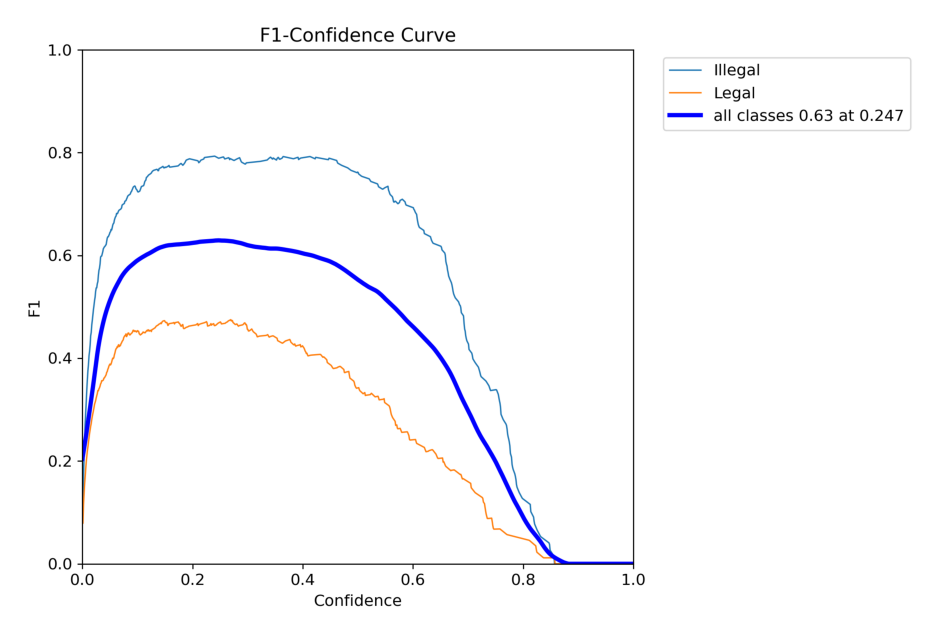

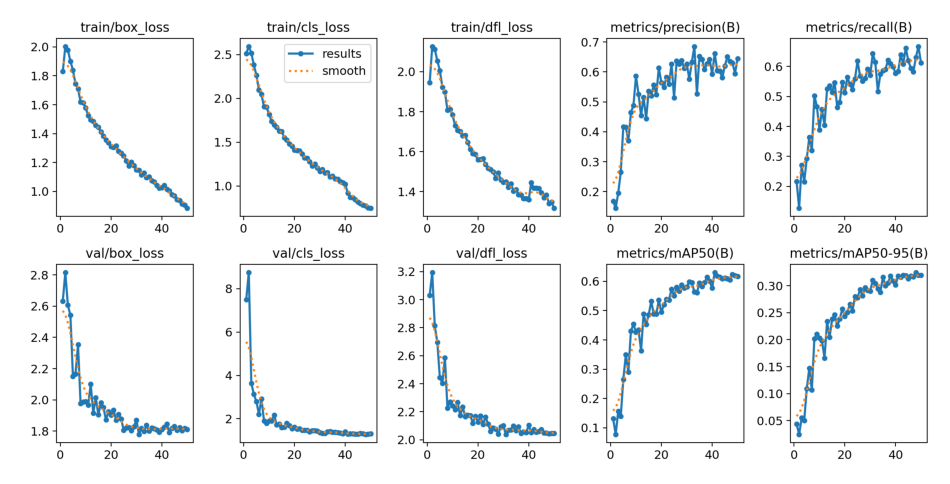

In [ ]:
list_of_metrics = ["P_curve.png", "R_curve.png", "confusion_matrix.png", "F1_curve.png", "results.png"]

for metric in list_of_metrics:
    image = Image.open(f'/content/runs/detect/train2/{metric}')
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()


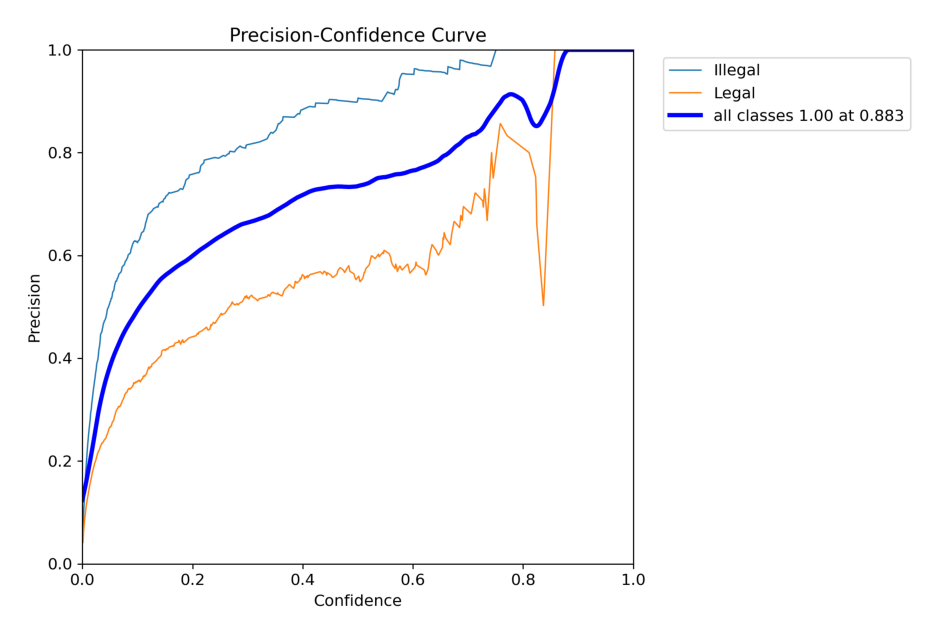

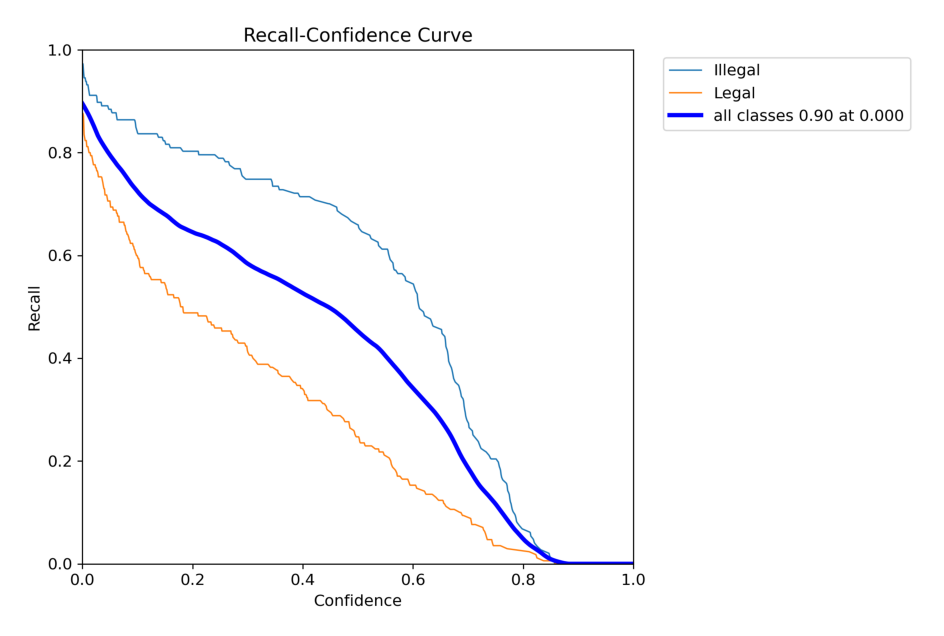

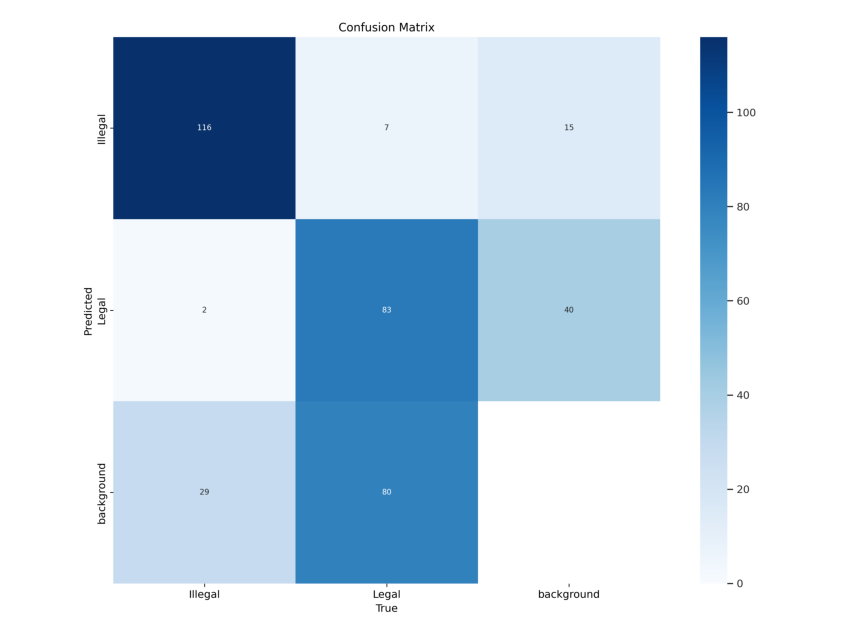

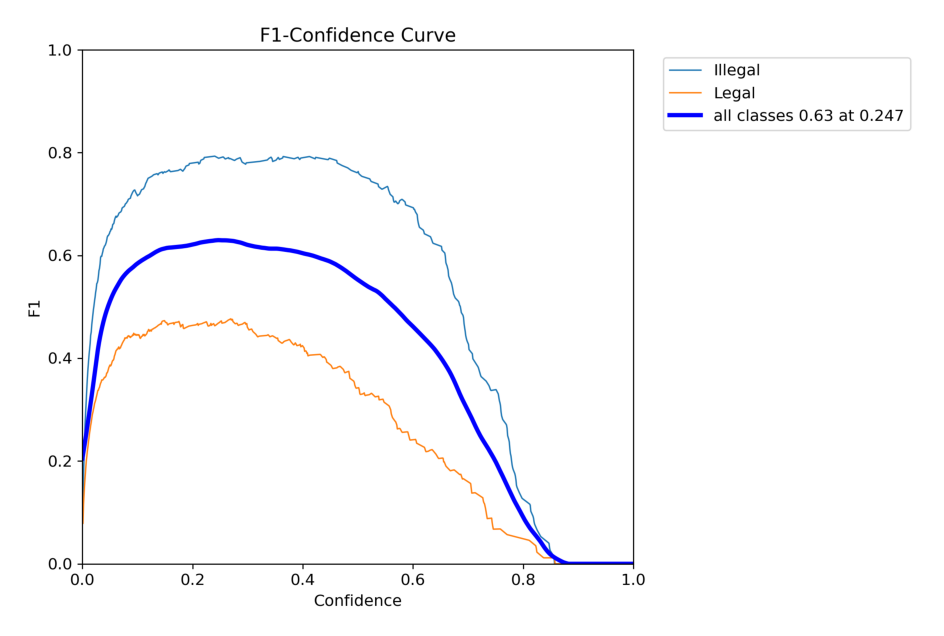

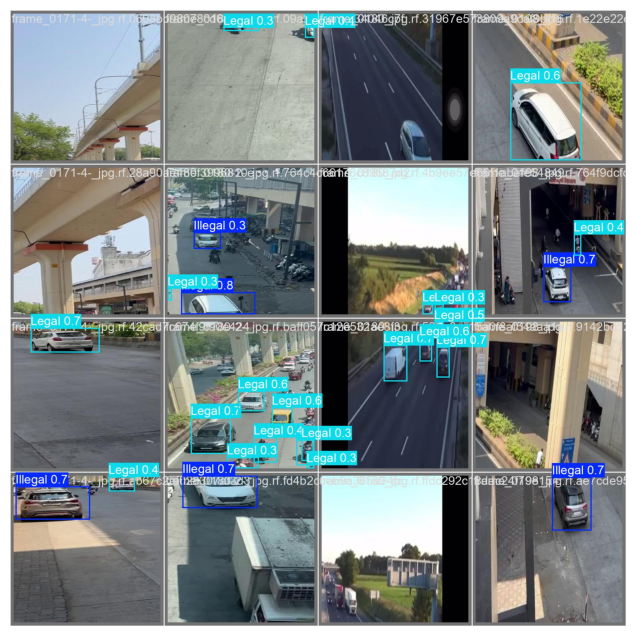

In [ ]:
list_of_metrics_1 = ["P_curve.png", "R_curve.png", "confusion_matrix.png", "F1_curve.png", "val_batch2_pred.jpg"]

for metric in list_of_metrics_1:
    image = Image.open(f'/content/runs/detect/train22/{metric}')
    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()



image 1/148 /content/test/images/frame_0000-7-_jpg.rf.33924de1bc08ede0827e8cd6d34d8ac0.jpg: 640x640 (no detections), 88.6ms
image 2/148 /content/test/images/frame_0000-7-_jpg.rf.93d482f0434df1351c1e3b4cf24a36b2.jpg: 640x640 3 Illegals, 1 Legal, 77.9ms
image 3/148 /content/test/images/frame_0000-7-_jpg.rf.9d86ce9e1aac60767153cdd9c48f0726.jpg: 640x640 (no detections), 89.9ms
image 4/148 /content/test/images/frame_0000-7-_jpg.rf.eda357eeb26debda52bc75ba1cb9dc10.jpg: 640x640 1 Illegal, 81.8ms
image 5/148 /content/test/images/frame_0026_jpg.rf.3199eebeaf8b5d60e9904397ef583dc5.jpg: 640x640 2 Legals, 87.7ms
image 6/148 /content/test/images/frame_0026_jpg.rf.34d173564496f343328146e9c2069b60.jpg: 640x640 (no detections), 46.0ms
image 7/148 /content/test/images/frame_0026_jpg.rf.b656db6bad154b7d3fad9af9eb0e6336.jpg: 640x640 (no detections), 58.4ms
image 8/148 /content/test/images/frame_0026_jpg.rf.e096f08ada4b2165f129d63ebf76ac60.jpg: 640x640 (no detections), 45.5ms
image 9/148 /content/test/im

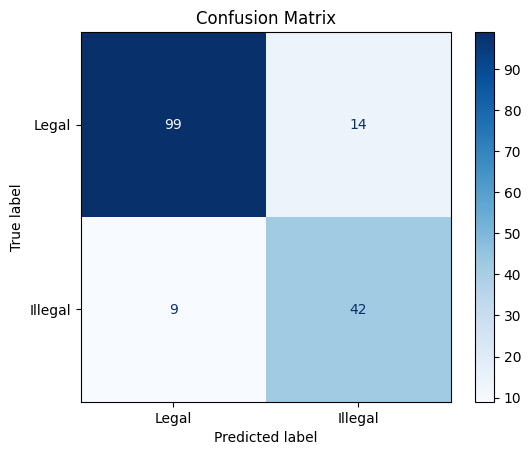

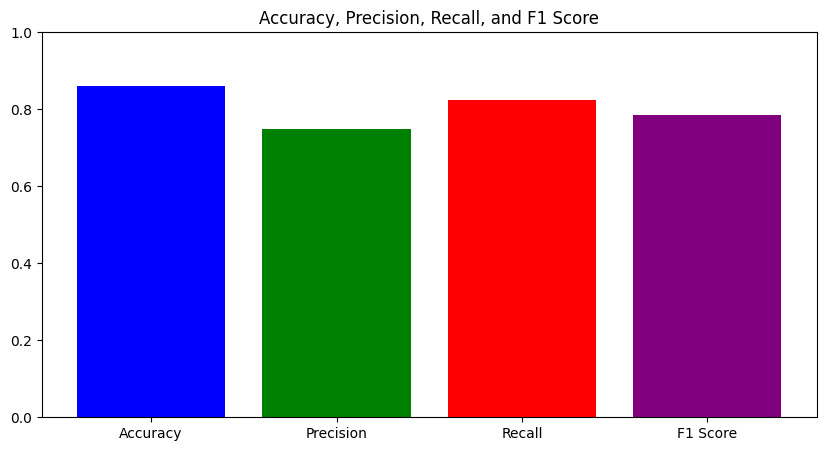

In [ ]:
import os
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Function to read ground truth labels from YOLO format annotation files
def read_ground_truth_labels(labels_path, image_file):
    label_file = os.path.join(labels_path, os.path.splitext(image_file)[0] + '.txt')
    if not os.path.exists(label_file):
        return []

    with open(label_file, 'r') as f:
        labels = [int(line.split()[0]) for line in f.readlines()]

    return labels

# Load your model
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # Replace with your model path

# Path to test images and labels
images_path = '/content/test/images'  # Replace with your test images path
labels_path = '/content/test/labels'  # Replace with your test labels path

# Perform inference
results = model.predict(images_path)

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate over the results
for result in results:
    image_file = os.path.basename(result.path)  # Get the image file name

    # Retrieve ground truth labels for the image
    ground_truth_labels = read_ground_truth_labels(labels_path, image_file)

    # Get predicted labels for the current image
    predicted_labels_current_image = [int(box.cls) for box in result.boxes]

    # Ensure both lists have the same length for comparison
    num_labels = min(len(ground_truth_labels), len(predicted_labels_current_image))
    y_true.extend(ground_truth_labels[:num_labels])
    y_pred.extend(predicted_labels_current_image[:num_labels])

# Compute accuracy, precision, recall, f1-score
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Legal", "Illegal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot accuracy, precision, recall, f1-score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title("Accuracy, Precision, Recall, and F1 Score")
plt.ylim([0, 1])
plt.show()


In [ ]:
trained_weights = "/content/runs/detect/train2/weights/best.pt"
model = YOLO(trained_weights)


In [ ]:
def test_visualization(images):
    output = model.predict(images)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11))
    for i, r in enumerate(images):
        ax = axes[i // 3, i % 3]
        im_bgr = cv2.imread(r)
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, r in enumerate(output):
        ax = axes[i // 3, i % 3]
        im_bgr = r.plot()  # BGR-order numpy array
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
        ax.axis('off')
        ax.set_title(f"Image {i}")
        ax.imshow(im_rgb)



0: 640x640 1 Legal, 36.4ms
1: 640x640 3 Legals, 36.4ms
2: 640x640 2 Illegals, 1 Legal, 36.4ms
3: 640x640 3 Legals, 36.4ms
4: 640x640 1 Legal, 36.4ms
5: 640x640 (no detections), 36.4ms
6: 640x640 1 Illegal, 36.4ms
7: 640x640 1 Legal, 36.4ms
8: 640x640 (no detections), 36.4ms
Speed: 5.2ms preprocess, 36.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


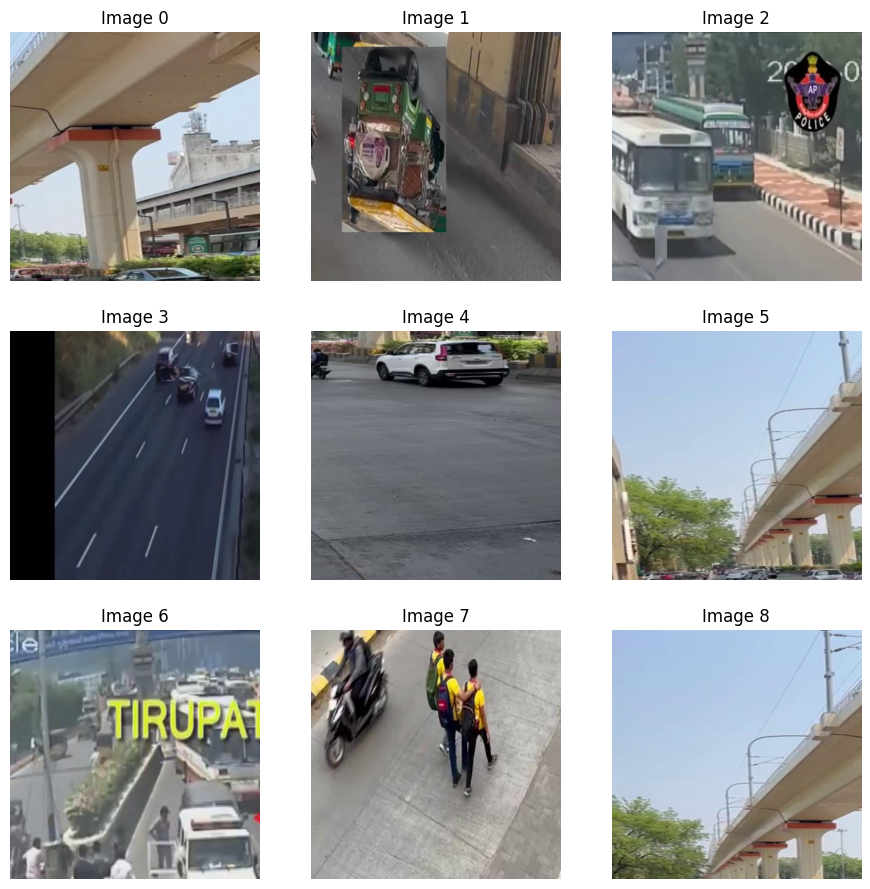

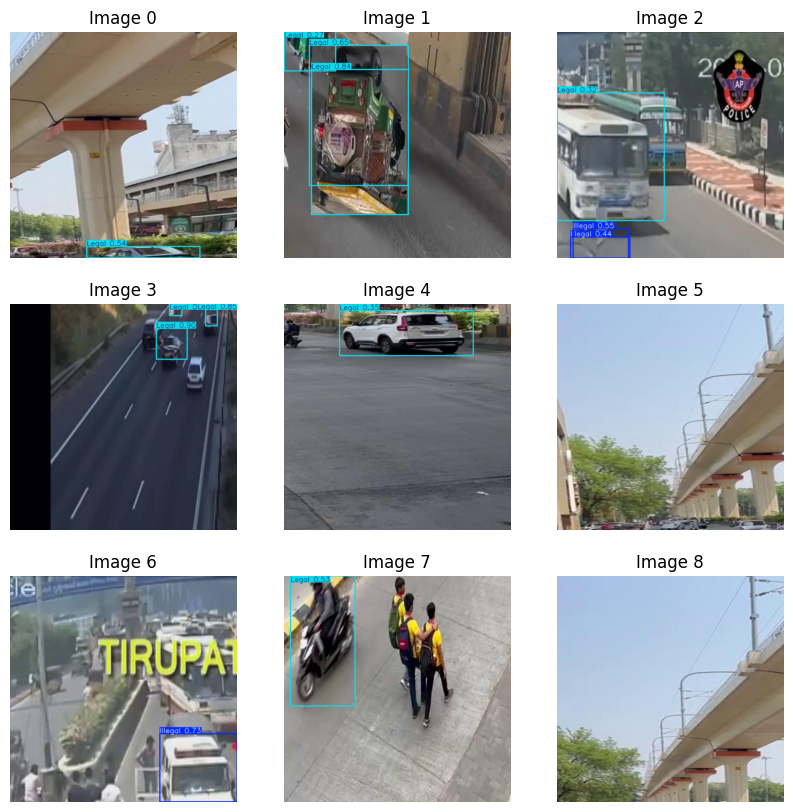

In [ ]:

import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2 # Import the cv2 module

# Verify the path exists
if os.path.exists('/content/train/images'):
    test_img_dir = '/content/train/images'
    test_images = os.listdir(test_img_dir)
    test_img = [os.path.join(test_img_dir, img) for img in test_images[:9]]

    test_visualization(test_img)




image 1/1 /content/drive/MyDrive/image111.jpg: 640x640 2 Illegals, 48.0ms
Speed: 2.5ms preprocess, 48.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
The parking is Illegal.


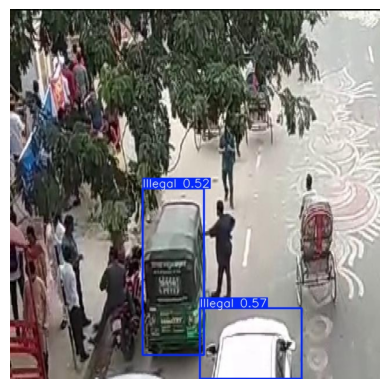

In [ ]:
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO('/content/runs/detect/train2/weights/best.pt')

# Define the path to the new image you want to test
new_image_path = '/content/drive/MyDrive/image111.jpg'

# Perform inference and get results
results = model.predict(source=new_image_path)

# Assuming 'results' is a list, iterate over each result
for result in results:
    detected_classes = [model.names[int(box[-1])] for box in result.boxes.data]

    # Print the results
    if 'Illegal' in detected_classes:
        print("The parking is Illegal.")
    else:
        print("The parking is Legal.")

    # Visualize the results
    result.show()

    # Save the output image, specify the full filename including directory
    result.save(filename='/content/predictions.jpg')  # Use 'filename' to specify the save path

# Load and display the saved image
output_image_path = '/content/predictions.jpg'  # This will be the saved image path
output_image = plt.imread(output_image_path)
plt.imshow(output_image)
plt.axis('off')
plt.show()